In [129]:
import mmcv
import numpy as np
import torch
from mmcv import Config
from torch import nn
from torch.nn import functional as F
from torch.nn import init
from torch.autograd import Variable

In [71]:
import matplotlib.pyplot as plt

In [10]:
cfg = Config.fromfile('./config1.py')
cfg

In [13]:
cfg = Config.fromfile('./config1.py')
cfg

Config (path: ./config1.py): {'loss_bbox': {'type': 'IoULoss', 'eps': 1e-06, 'loss_weight': 1.0, 'reduction': 'none'}}

In [19]:
cfg.loss_bbox

{'type': 'IoULoss', 'eps': 1e-06, 'loss_weight': 1.0, 'reduction': 'none'}

In [37]:
class Dict(dict):
    def __init__(self, *args):
        super().__init__()
        for arg in args:
            for key, val in arg.items():
                # 对字典对象进行属性设置，并进行迭代
                self[key] = self._hook(val)
                
    def _hook(self, item):
        if isinstance(item, dict):
            return Dict(item)  # 递归调用
        return item
        
    def __getattr__(self, item):
        print('getattr')
        return self[item]

In [38]:
a = Dict({'key1' : 123})

In [41]:
a.key1

123

In [1]:
fun = lambda x1,x2 : x1*x2

In [2]:
fun(5, 6)

30

In [5]:
file_json = mmcv.load('./tmp.json')

In [11]:
file_json

{'sites': [{'name': '菜鸟教程', 'url': 'www.runoob.com'},
  {'name': 'google', 'url': 'www.google.com'},
  {'name': '微博', 'url': 'www.weibo.com'}]}

In [10]:
type(file_json)

dict

In [10]:
def bbox_overlaps(bboxes1, bboxes2, mode='iou'):
    """Calculate the ious between each bbox of bboxes1 and bboxes2.
    Args:
        bboxes1(ndarray): shape (n, 4)
        bboxes2(ndarray): shape (k, 4)
        mode(str): iou (intersection over union) or iof (intersection
            over foreground)
    Returns:
        ious(ndarray): shape (n, k)
    """
    
    assert mode in ['iou', 'iof']
    
    bboxes1 = bboxes1.astype(np.float32)
    bboxes2 = bboxes2.astype(np.float32)
    rows = bboxes1.shape[0]
    cols = bboxes2.shape[0]
    ious = np.zeros((rows, cols), dtype=np.float32)
    if rows * cols == 0:
        return ious
    exchange = False
    if bboxes1.shape[0] > bboxes2.shape[0]:
        bboxes1, bboxes2 = bboxes2, bboxes1
        ious = np.zeros((cols, rows), dtype=np.float32)
        exchange = True
    area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (
        bboxes1[:, 3] - bboxes1[:, 1] + 1)
    area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (
        bboxes2[:, 3] - bboxes2[:, 1] + 1)
    for i in range(bboxes1.shape[0]):
        x_start = np.maximum(bboxes1[i, 0], bboxes2[:, 0])
        y_start = np.maximum(bboxes1[i, 1], bboxes2[:, 1])
        x_end = np.minimum(bboxes1[i, 2], bboxes2[:, 2])
        y_end = np.minimum(bboxes1[i, 3], bboxes2[:, 3])
        print(x_start, y_start, x_end, y_end)
        overlap = np.maximum(x_end - x_start + 1, 0) * np.maximum(
            y_end - y_start + 1, 0)
        print(overlap)
        print(area1[i])
        print(area2)
        if mode == 'iou':
            union = area1[i] + area2 - overlap
        else:
            union = area1[i] if not exchange else area2
        ious[i, :] = overlap / union
    if exchange:
        ious = ious.T
    return ious


In [11]:
bbox_overlaps(np.array([[1,1,2,2]]), np.array([[1,1,2,2], [2,2,2,2], [4,4,2,2]]))

[1. 2. 3.] [1. 2. 3.] [2. 2. 2.] [2. 2. 2.]
[4. 1. 0.]
4.0
[4. 1. 0.]


array([[1.  , 0.25, 0.  ]], dtype=float32)

In [5]:
a>0

tensor([ True,  True, False,  True])

In [12]:
mmcv.is_str
@DETECTORS.register_module

[{'name': '菜鸟教程', 'url': 'www.runoob.com'},
 {'name': 'google', 'url': 'www.google.com'},
 {'name': '微博', 'url': 'www.weibo.com'}]

In [3]:
a = torch.rand(3,3,96,96)

In [27]:
conv1 = nn.Conv2d(3, 3, kernel_size=3, padding = 1, stride = 2)

In [36]:
class Residual(nn.Module):
    def __init__(self, input_channel, output_channel, use_conv = False, strides = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size = 3, padding = 1, stride = strides)
        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size = 3, padding = 1)
        if use_conv:
            self.conv3 = nn.Conv2d(input_channel, output_channel, kernel_size = 1, stride = strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(output_channel)
        self.bn2 = nn.BatchNorm2d(output_channel)
        self.relu = nn.ReLU(inplace = True)
        self.use_conv = use_conv
        self.strides = strides
    
    def forward(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu(y)
        
        y = self.conv2(y)
        y = self.bn2(y)
        
        if self.use_conv:
            print('before 1*1', x.shape)
            x = self.conv3(x)
            print('after 1*1', x.shape)
            y += x
        
        y = self.relu(y)
        return y

In [39]:
m = Residual(3, 6, True, 2)

In [40]:
print(a.shape)
b = m(a)
print(b.shape)

torch.Size([3, 3, 96, 96])
before 1*1 torch.Size([3, 3, 96, 96])
after 1*1 torch.Size([3, 6, 48, 48])
torch.Size([3, 6, 48, 48])


In [44]:
bn = nn.BatchNorm2d(3)

In [41]:
class BatchNorm(nn.Module): 
    # `num_features`：完全连接层的输出数量或卷积层的输出通道数。 
    # `num_dims`：2表⽰完全连接层，4表⽰卷积层 
    def __init__(self, num_features, num_dims): 
        super().__init__() 
        if num_dims == 2: 
            shape = (1, num_features)
        else: 
            shape = (1, num_features, 1, 1)
    # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0 
        self.gamma = nn.Parameter(torch.ones(shape)) 
        self.beta = nn.Parameter(torch.zeros(shape)) 
    # ⾮模型参数的变量初始化为0和1 
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(x):
        

IndentationError: expected an indented block (3945509248.py, line 4)

In [50]:
with torch.no_grad():
    print(torch.is_grad_enabled())

False


In [53]:
fn = nn.Dropout(0.2)
print(fn)
with torch.no_grad():
    print(fn)

Dropout(p=0.2, inplace=False)
Dropout(p=0.2, inplace=False)


In [54]:
d = {'abc':3,'bc':2, 'de':4}

In [58]:
sorted(d.items(), key = lambda x: -x[1])

[('de', 4), ('abc', 3), ('bc', 2)]

In [59]:
import copy

In [68]:
list1 = [[1,2],2,3]
list2 = list(list1)
list3 = copy.deepcopy(list1)

In [70]:
list1[0].append(3)

In [71]:
list1

[[1, 2, 3], 2, 3]

In [72]:
list2

[[1, 2, 3], 2, 3]

### Focal Loss

In [65]:
def focal_loss(preds, gts, reduction = None):
    """[focal loss]
    - alpha_class * (1-p_class) ** gamma * log(p_class)

    Args:
        preds ([type]): [description]
        gts ([type]): [description]
    """
    alpha = torch.full([preds.shape[1]], 0.25)
    
    pred_softmax = F.softmax(preds, dim=1) # p_class
    pred_log = torch.log(pred_softmax) # log(p_class)
    
    pred_softmax = torch.gather(pred_softmax, 1, gts.view(-1, 1))
    pred_log = torch.gather(pred_log, 1, gts.view(-1, 1))
    alpha_class = torch.gather(alpha, 0, gts.view(-1)).view(-1, 1)
    
    gamma = 2
    print(pred_softmax.shape)
    print('alpha_class', alpha_class.shape)
    
    loss = - alpha_class * (1 - pred_softmax) ** gamma * pred_log
    
    print(loss.shape)
    
    if reduction:
        if reduction == 'mean':
            loss = loss.mean()
        elif reduction == 'sum':
            loss = loss.sum()
    print(loss.shape)
    return loss

In [55]:
preds = torch.rand(5, 10)
labels = torch.randint(0, 10, (5,))

In [66]:
focal_loss(preds, labels, 'sum')

torch.Size([5, 1])
alpha_class torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([])


tensor(2.4082)

### Kmeans

In [81]:
data = torch.randn((10000, 2))

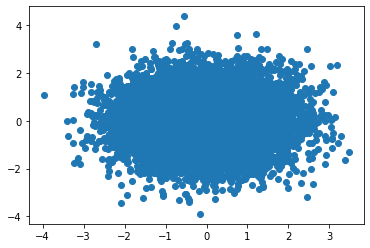

In [82]:
plt.scatter(*data.T)

In [84]:
ids = np.random.choice(range(data.shape[0]), 10, replace=False)

In [111]:
def kmean(data, k = 10, iterations = 3):
    center_id = np.random.choice(range(data.shape[0]), k, replace=False)
    mp =  np.zeros(data.shape[0])
    centers = data[center_id]
    
    has_change = False
    num_iter = 0
    while ~has_change and num_iter < iterations:
        num_iter += 1
        for i in range(data.shape[0]):
            mindist = float('inf')
            minid = k - 1
            for j in range(k):
                dist = np.linalg.norm((data[i] - centers[j]))
                if dist < mindist:
                    mindist = dist
                    minid = j
            mp[i] = minid
        
        for i in range(k):
            datak = data[np.where(mp == i)]
            centers[i] = datak.mean(dim = 0)
            
    return centers, mp

In [115]:
centers, mp = kmean(data, 5, 10)

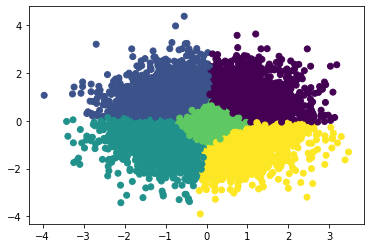

In [116]:
color_label = ['c', 'b', 'g', 'r', 'm', 'y', 'k', 'w']
plt.scatter(*data.T, c=mp)

### Smooth l1

In [126]:
def smoothl1(x, y, beta = 1):
    diff = torch.abs(y - x)
    loss = torch.where(diff > beta, diff - 0.5 * beta, 0.5 * diff * diff / beta)
    return loss

In [127]:
x = torch.tensor([1,2,3])
y = torch.tensor([1.2,3,9])

In [128]:
smoothl1(x, y)

tensor([0.0200, 0.5000, 5.5000])

### Deconvolution

In [133]:
dconv = nn.ConvTranspose2d(in_channels=1, out_channels= 1, kernel_size=3, stride=2, padding=1,output_padding=0, bias= False)
init.constant(dconv.weight, 1)
print(dconv.weight)

input = Variable(torch.ones(1, 1, 2, 2))
print(input.shape)
print(dconv(input).shape)

Parameter containing:
tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], requires_grad=True)
torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 1, 1])


/home/ruize/miniconda3/envs/mmdet/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  
